<a href="https://colab.research.google.com/github/tmmridho/hacktiv8/blob/main/PYIM_Assgn_3_8_Teuku_Muhammad_Mifdhal_Ridho.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import library

In [20]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Create graphic

In [2]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

# Input dataset

In [3]:
dataset, info = tfds.load('amazon_us_reviews/Digital_Video_Games_v1_00', with_info=True, as_supervised=False)

train_dataset= dataset['train']

train_dataset.element_spec

{'data': {'customer_id': TensorSpec(shape=(), dtype=tf.string, name=None),
  'helpful_votes': TensorSpec(shape=(), dtype=tf.int32, name=None),
  'marketplace': TensorSpec(shape=(), dtype=tf.string, name=None),
  'product_category': TensorSpec(shape=(), dtype=tf.string, name=None),
  'product_id': TensorSpec(shape=(), dtype=tf.string, name=None),
  'product_parent': TensorSpec(shape=(), dtype=tf.string, name=None),
  'product_title': TensorSpec(shape=(), dtype=tf.string, name=None),
  'review_body': TensorSpec(shape=(), dtype=tf.string, name=None),
  'review_date': TensorSpec(shape=(), dtype=tf.string, name=None),
  'review_headline': TensorSpec(shape=(), dtype=tf.string, name=None),
  'review_id': TensorSpec(shape=(), dtype=tf.string, name=None),
  'star_rating': TensorSpec(shape=(), dtype=tf.int32, name=None),
  'total_votes': TensorSpec(shape=(), dtype=tf.int32, name=None),
  'verified_purchase': TensorSpec(shape=(), dtype=tf.int64, name=None),
  'vine': TensorSpec(shape=(), dtype=tf

# Load data into dataframe

In [5]:
df = tfds.as_dataframe(dataset['train'], info)
df.head()

,data/customer_id,data/helpful_votes,data/marketplace,data/product_category,data/product_id,data/product_parent,data/product_title,data/review_body,data/review_date,data/review_headline,data/review_id,data/star_rating,data/total_votes,data/verified_purchase,data/vine
0,b'2260456',0,b'US',b'Digital_Video_Games',b'B00F4CEHNK',b'341969535',b'Xbox Live Gift Card',b'Great.',b'2015-03-30',b'Five Stars',b'R2THVSPD17067F',5,0,0,1
1,b'8803476',0,b'US',b'Digital_Video_Games',b'B00GAC1D2G',b'384246568',b'Playstation Network Card',b'very good',b'2015-08-14',b'Five Stars',b'R310RKYQ2QA7SB',5,0,0,1
2,b'18246487',3,b'US',b'Digital_Video_Games',b'B00AYHGAF8',b'442068496',b'The Sims 3: Monte Vista',"b""Anything that enables one to make his or her...",b'2013-03-29',b'Mmmmm...Pizza!',b'R1BFVTJH7VKPIK',5,4,0,1
3,b'16355070',0,b'US',b'Digital_Video_Games',b'B004RMK57U',b'53534661',b'Playstation Plus Subscription',b'simply excellent thanks amazon...',b'2014-08-06',b'Five Stars',b'R247D4LDWYXRZY',5,0,0,1
4,b'43587014',0,b'US',b'Digital_Video_Games',b'B00K59HKIQ',b'384246568',b'Playstation Network Card',b'Excellent',b'2015-03-23',b'Five Stars',b'R2KPD6KLMXXYOF',5,0,0,1


In [6]:
len(df)

145431

# Remove neutral data

In [7]:
df_clean = df[df['data/star_rating'] != 3]
len(df_clean)

133802

# Remap value

In [11]:
df_clean['sentiment'] = df_clean['data/star_rating'].apply(lambda score: 'positive' if score > 3 else 'negative')
df_clean['sentiment'] = df_clean['sentiment'].map({'positive':1, 'negative':0})
df_clean['review'] =df_clean['data/review_body'].str.decode("utf-8")
df_fix = df_clean[["review", "sentiment"]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [13]:
df_fix.head()

,review,sentiment
0,Great.,1
1,very good,1
2,Anything that enables one to make his or her o...,1
3,simply excellent thanks amazon...,1
4,Excellent,1


In [22]:
df_fix['sentiment'].unique()

array([1, 0])

# Split train and test data

In [28]:
df_fix.reset_index()
benchmark = int(0.8 * len(df_fix))
train_df = df_fix.iloc[:benchmark, :]
test_df = df_fix.iloc[benchmark:, :]

In [29]:
len(train_df), len(test_df)

(107041, 26761)

In [30]:
x_train = train_df['review'].values.tolist()
y_train = train_df['sentiment'].tolist()

In [31]:
x_test = test_df['review'].values.tolist()
y_test = test_df['sentiment'].tolist()

In [32]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [33]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Check data type

In [34]:
train_dataset

<PrefetchDataset shapes: ((None,), (None,)), types: (tf.string, tf.int32)>

In [35]:
test_dataset

<PrefetchDataset shapes: ((None,), (None,)), types: (tf.string, tf.int32)>

In [36]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'Our familiy loves this game! It is very fun and entertaining. Some of the content can be a litte racy, but in a humourous way. That is why it is rated T for Teens.'
 b'If you\'re a fan of the previous versions of Mass Effect, the first 99.98% or so of this game is a visual and story delight. The story held you. Decisions made in previous games and earlier in this one had and held weight. The story flowed from story mode to combat with a grace not really seen in the series before.<br /><br />And then Bioware completely destroys all that good will with an ending that trivializes all that was good about it to that point.<br /><br />Want to know why? I won\'t spoil you here - however, go into the Bioware forums, or look on Youtube for \\\\"Mass Effect 3 endings\\\\" and watch the comments. Good luck finding one from someone who has played the series that doesn\'t say \\\\"what the...?!?\\\\" somewhere in it.<br /><br />Either the writers ran out of time (unused audio files found

# Text encoder

In [37]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [38]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'to', 'and', 'i', 'a', 'it', 'game', 'of',
       'is', 'you', 'this', 'for', 'in', 'that', 'but', 'on', 'have',
       'with'], dtype='<U13')

In [39]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[654,   1, 745, ...,   0,   0,   0],
       [ 27, 185,   6, ...,   0,   0,   0],
       [  2,   8, 340, ...,   0,   0,   0]])

In [40]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'Our familiy loves this game! It is very fun and entertaining. Some of the content can be a litte racy, but in a humourous way. That is why it is rated T for Teens.'
Round-trip:  our [UNK] loves this game it is very fun and entertaining some of the content can be a [UNK] [UNK] but in a [UNK] way that is why it is [UNK] [UNK] for [UNK]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

Original:  b'If you\'re a fan of the previous versions of Mass Effect, the first 99.98% or so of this game is a visual and story delight. The story held you. Decisions made in p

# Create model

In [41]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [42]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [45]:
# predict on a sample text without padding.

sample_text = ('This game is very good')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[0.00650971]


In [46]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[0.00650971]


In [47]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

# Train the model

In [48]:
history = model.fit(train_dataset, epochs=15,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/15
1673/1673 [==============================] - 280s 164ms/step - loss: 0.3232 - accuracy: 0.8270 - val_loss: 0.2220 - val_accuracy: 0.9161
Epoch 2/15
1673/1673 [==============================] - 269s 161ms/step - loss: 0.2189 - accuracy: 0.9105 - val_loss: 0.2072 - val_accuracy: 0.9224
Epoch 3/15
1673/1673 [==============================] - 249s 149ms/step - loss: 0.2098 - accuracy: 0.9142 - val_loss: 0.1999 - val_accuracy: 0.9245
Epoch 4/15
1673/1673 [==============================] - 274s 164ms/step - loss: 0.2050 - accuracy: 0.9153 - val_loss: 0.1999 - val_accuracy: 0.9255
Epoch 5/15
1673/1673 [==============================] - 280s 168ms/step - loss: 0.2002 - accuracy: 0.9177 - val_loss: 0.1983 - val_accuracy: 0.9266
Epoch 6/15
1673/1673 [==============================] - 287s 172ms/step - loss: 0.1953 - accuracy: 0.9189 - val_loss: 0.1964 - val_accuracy: 0.9255
Epoch 7/15
1673/1673 [==============================] - 289s 173ms/step - loss: 0.1914 - accuracy: 0.9218 - val_

In [49]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

419/419 [==============================] - 17s 41ms/step - loss: 0.2000 - accuracy: 0.9147
Test Loss: 0.1999959945678711
Test Accuracy: 0.914689302444458


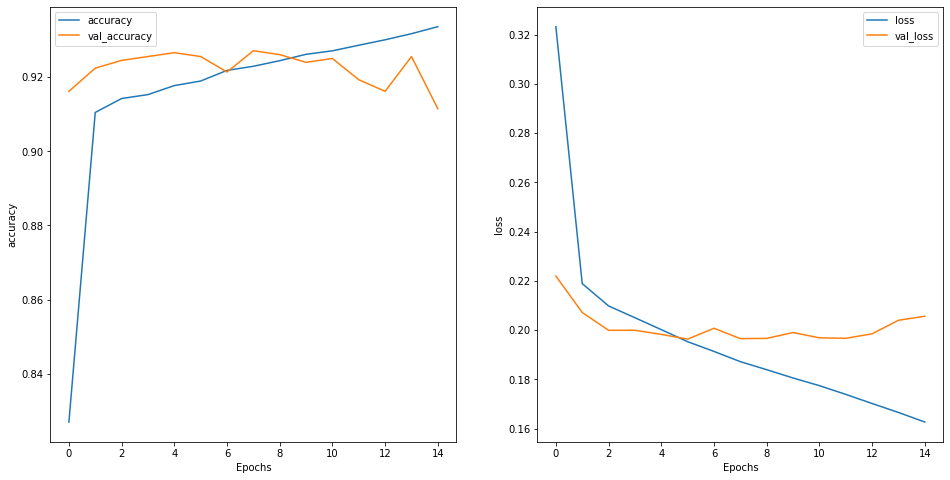

In [51]:
# Visualization
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [52]:
sample_text = ('This game is very good')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[4.706659]]


In [53]:
sample_text1 = ('This is the worst game ever')
predictions1 = model.predict(np.array([sample_text1]))
print(predictions1)

[[-4.558809]]


In [54]:
model.save('nlp_model')

INFO:tensorflow:Assets written to: nlp_model/assets


INFO:tensorflow:Assets written to: nlp_model/assets


# Create model with two or more LSTM layer

In [55]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [56]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

# Train model with two LSTM layers

In [58]:
history = model.fit(train_dataset, epochs=15,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/15
1673/1673 [==============================] - 525s 310ms/step - loss: 0.3319 - accuracy: 0.8187 - val_loss: 0.2305 - val_accuracy: 0.9042
Epoch 2/15
1673/1673 [==============================] - 516s 308ms/step - loss: 0.2273 - accuracy: 0.9092 - val_loss: 0.2260 - val_accuracy: 0.9214
Epoch 3/15
1673/1673 [==============================] - 537s 321ms/step - loss: 0.2157 - accuracy: 0.9124 - val_loss: 0.2048 - val_accuracy: 0.9250
Epoch 4/15
1673/1673 [==============================] - 487s 291ms/step - loss: 0.2096 - accuracy: 0.9145 - val_loss: 0.2109 - val_accuracy: 0.9208
Epoch 5/15
1673/1673 [==============================] - 479s 286ms/step - loss: 0.2050 - accuracy: 0.9161 - val_loss: 0.2013 - val_accuracy: 0.9271
Epoch 6/15
1673/1673 [==============================] - 525s 314ms/step - loss: 0.2018 - accuracy: 0.9177 - val_loss: 0.1989 - val_accuracy: 0.9260
Epoch 7/15
1673/1673 [==============================] - 510s 305ms/step - loss: 0.1967 - accuracy: 0.9200 - val_

In [59]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

419/419 [==============================] - 27s 65ms/step - loss: 0.1956 - accuracy: 0.9266
Test Loss: 0.1955687254667282
Test Accuracy: 0.9265722632408142


In [60]:
sample_text = ('I love this game so much. I enjoy all of the story.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[7.95726]]


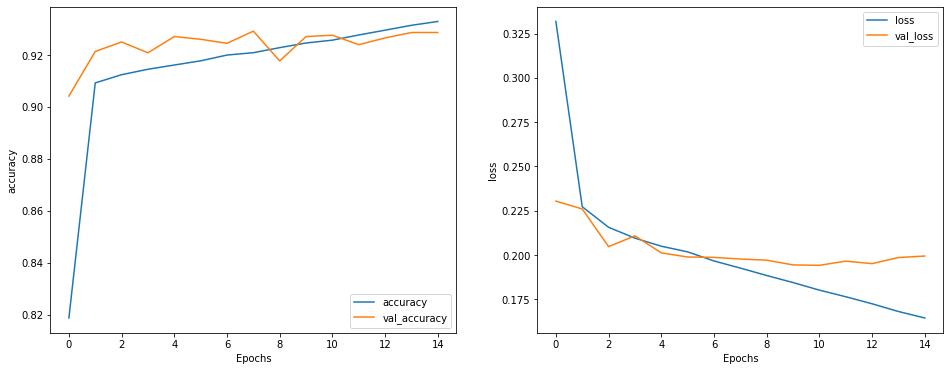

In [61]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [62]:
model.save('nlp_model_2lstm')

INFO:tensorflow:Assets written to: nlp_model_2lstm/assets


INFO:tensorflow:Assets written to: nlp_model_2lstm/assets
